# Feature ranking and model robustness

In this notebook we will go step-by-step through the feature ranking and model robustness part of our paper.

For more information read the experiment description in our paper:

TODO: Include Ref

Note: If you want to run this notebook locally and reproduce the figures of our paper

- make sure you have our pre-trained models. See the README.md in the repository for further instructions.

- make sure to have the CAMELS data set, containing the updated Maurer forcings. See the README.md in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the README.md in the repository for further instructions.

#### Adapt the lines below according to your local system

In [1]:
# Path to the main CAMELS folder
CAMELS_DIR = "/datadisk/data/CAMELS/"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/frederik/projects/ealstm_in_hydrology"

# Needed if no precomputed results are used. Path to a single run
BASE_RUN_DIR = "/datadisk/data/EALSTM_PAPER/runs/run_1906_1004_seed111"

# Filenames of precomputed results
RANKING_FILE = "run_1906_1004_seed111_feature_ranking.p"
ROBUSTNESS_FILE = "run_1906_1004_seed111_model_robustness.p"

In [2]:
# Imports
import json
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from bokeh.sampledata import us_states
import matplotlib.lines as mlines
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

sys.path.append(BASE_CODE_DIR)
from main import Model
from papercode.datasets import CamelsTXT
from papercode.datautils import load_attributes
from papercode.morris import get_morris_gradient
from papercode.plotutils import attribute_draw_style, get_shape_collections
from papercode.utils import get_basin_list

# get polygon points of all CONUS states
us_states = us_states.data.copy()
del us_states["HI"]
del us_states["AK"]

Definition of global variables. 

**Note**: If you want to recompute the feature rankings (for possibly a different seed), change the `PRECOMPUTED_RANKING` flag to `False`. Having a CUDA ready GPU available is of advantage. Otherwise, the calculations might take some time. If you want to use the pre-calculated data, make sure the flag is set to `True`

In [3]:
# True if using precomputed data
PRECOMPUTED_RANKING = True 

# Use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Start and end date of the validation period
VAL_START = pd.to_datetime('01101989', format='%d%m%Y')
VAL_END = pd.to_datetime('30091999', format='%d%m%Y')

# Convert to PosixPaths
CAMELS_DIR = Path(CAMELS_DIR)
BASE_RUN_DIR = Path(BASE_RUN_DIR)

# Feature ranking

Setup everything we need to calculate the feature rankings, which is mainly to initialize the model and load the pre-trained weights.

In [4]:
# get list of modeled basins
basins = get_basin_list()

if not PRECOMPUTED_RANKING:
    # load run config
    with open(BASE_RUN_DIR / "cfg.json", "r") as fp:
        cfg = json.load(fp)
    
    # load means/stds from training period
    attributes = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"), 
                                 basins=basins,
                                 drop_lat_lon=True)
    means = attributes.mean()
    stds = attributes.std()

    # Initialize new model
    model = Model(input_size_dyn=5,
                  input_size_stat=27,
                  hidden_size=cfg["hidden_size"],
                  dropout=cfg["dropout"]).to(DEVICE)
    
    # load pre-trained weights
    weight_file = BASE_RUN_DIR / "model_epoch30.pt"
    model.load_state_dict(torch.load(weight_file, map_location=DEVICE))

Now we calculate for each basin and each sample of validation period the gradients w.r.t. the static input features (the catchment attributes). For more details regarding the method, see the description in the experimental setup of the paper.
Afterwards we calculated the mean absolute gradient per basin.

In [5]:
if not PRECOMPUTED_RANKING:
    feature_ranking = {}
    for basin in tqdm(basins):
        ds_test = CamelsTXT(camels_root=CAMELS_DIR,
                            basin=basin,
                            dates=[VAL_START, VAL_END],
                            is_train=False,
                            with_attributes=True,
                            attribute_means=means,
                            attribute_stds=stds,
                            db_path=str(BASE_RUN_DIR / "attributes.db"))
        loader = DataLoader(ds_test, batch_size=1024, shuffle=False, num_workers=0)

        gradients = get_morris_gradient(model, loader)

        mean_abs_gradient = np.mean(np.abs(gradients), axis=0)

        # convert to pandas Series
        data = {}
        for name, value in zip(list(ds_test.attribute_names), mean_abs_gradient):
            data[name] = value
        feature_ranking[basin] = pd.Series(data=data)
        
    out_file = f"{BASE_RUN_DIR.name}_feature_ranking.p" 
    with open(out_file, "wb") as fp:
        pickle.dump(feature_ranking, fp)
        
else:
    with open(RANKING_FILE, "rb") as fp:
        feature_ranking = pickle.load(fp)
    print("Loaded pre-computed feature ranking from file")

Loaded pre-computed feature ranking from file


To combine the results of multiple basins, first all feature sensitivities are normalized per basin to the range (0,1). Then the values of all basins are combined and the overall averages per feature reported.

In [6]:
normalized_ranks = {}
for basin, ranks in feature_ranking.items():
    ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
    normalized_ranks[basin] = ranks
df = pd.DataFrame(data={basin: ranks for basin, ranks in normalized_ranks.items()})
df.mean(axis=1).sort_values(ascending=False)

p_mean                  0.682248
aridity                 0.564276
area_gages2             0.504591
elev_mean               0.459893
high_prec_dur           0.406671
frac_snow               0.405564
high_prec_freq          0.382006
slope_mean              0.370855
geol_permeability       0.352949
carbonate_rocks_frac    0.339022
clay_frac               0.330383
pet_mean                0.310769
low_prec_freq           0.299585
soil_depth_pelletier    0.273934
p_seasonality           0.272786
frac_forest             0.267421
sand_frac               0.255156
soil_conductivity       0.243641
low_prec_dur            0.219104
gvf_max                 0.213809
gvf_diff                0.212412
lai_diff                0.208096
soil_porosity           0.194036
soil_depth_statsgo      0.191936
lai_max                 0.190274
silt_frac               0.183365
max_water_content       0.158722
dtype: float64

## Spatial plot

In the following map, we show each basin of the data set and mark it according to the highest ranked feature in the specific basin.

The `marker` and `color` are defined by the group a certain feature belongs to. The groups are `soil` (shades of yellows to brown), `climate` (shades of blues), `vegetation` (shades of greens) and `topology/generic` (shades of pink).


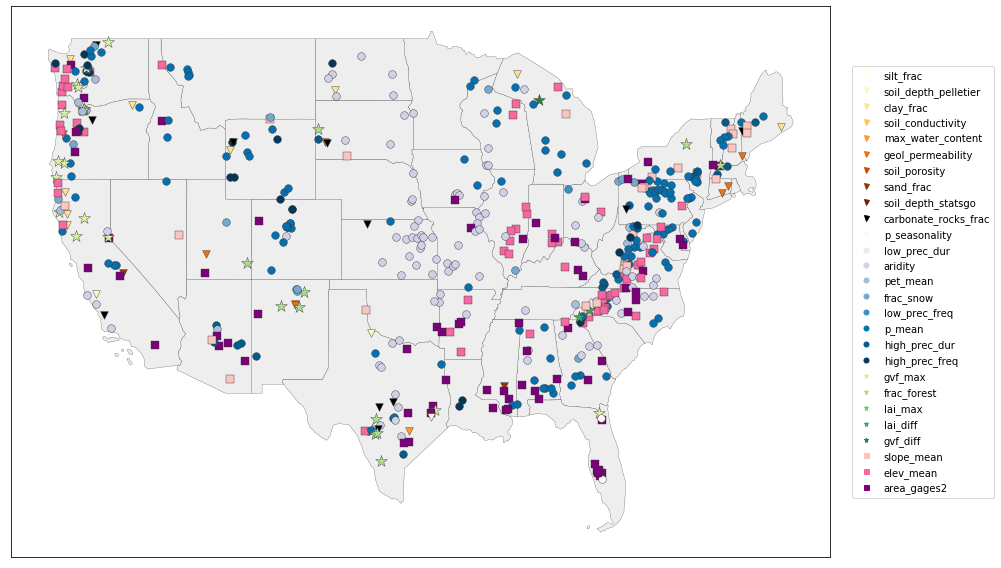

In [7]:
df_attributes = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"), 
                                basins=basins, 
                                drop_lat_lon=False)
fig, ax = plt.subplots(figsize=(14,8))

collection = get_shape_collections(us_states)
ax.add_collection(collection)

lats, lons, colors, markers = [], [], [], []
for basin in df.columns:
    lats.append(df_attributes.loc[df_attributes.index == basin, 'gauge_lat'][0])
    lons.append(df_attributes.loc[df_attributes.index == basin, 'gauge_lon'][0])
    top_feature = df[basin].sort_values(ascending=False).index[0]
    colors.append(attribute_draw_style[top_feature]['color'])
    markers.append(attribute_draw_style[top_feature]['marker'])
    
for lat, lon, color, marker in zip(lats, lons, colors, markers):
    scale = 60 if marker != '*' else 150
    points = ax.scatter(lon, lat, c=color, s=scale, zorder=2, marker=marker,
                        edgecolor='#333333', linewidth=0.4)

circles = []
for feature, style in attribute_draw_style.items():
    circles.append(mlines.Line2D([], [], 
                                 color=style['color'], 
                                 marker=style['marker'], 
                                 linestyle='None',
                                 markersize=5, 
                                 label=feature))
ax.legend(handles=circles, loc='center left', bbox_to_anchor=(1.02, 0.5))

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

plt.tight_layout()

# Model robustness

Next we analyse the results of the model robustness experiment. In this experiment, gaussian noise with an increasing standard deviation was added to the static catchment attributes (50 random draws per std level and basin) and then the model evaluated with the noisy static inputs. Because this experiments takes a long time to run (50 * 531 * 10 = 265 000 model evaluations of the entire validation period), precomputed results are provided.

If you want to recompute the results (or compute the results for a different random seed) run the following line of code from within the repository folder.

`python main.py eval_robustness --camels_root=/path/to/CAMELS --run_dir=/path/to/model/run`

In [8]:
with open(ROBUSTNESS_FILE, 'rb') as fp:
    data = pickle.load(fp)
    
results = defaultdict(list)
for basin, values in data.items():
    for scale, vals in values.items():
        results[scale] += vals

## Boxplot of the results.



Text(0.5, 1.0, 'Effect of noise on the static catchment attributes')

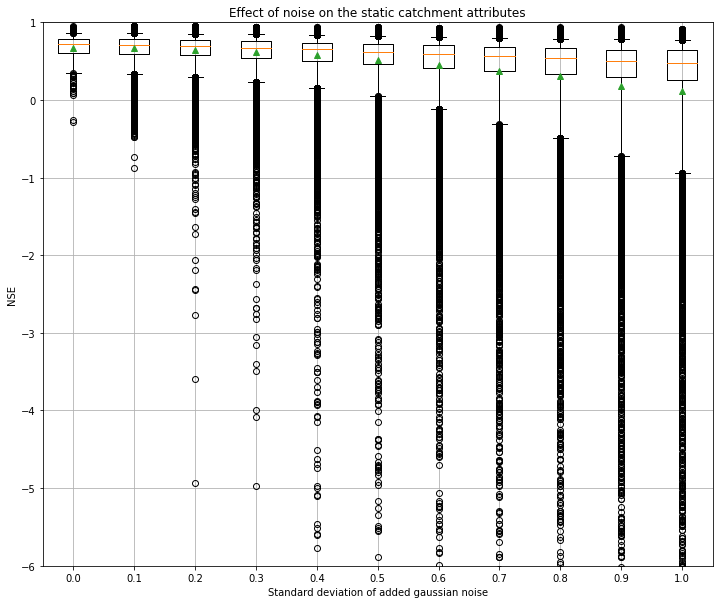

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
data = []
labels = []
for key, val in sorted(results.items()):
    data.append(val)
    labels.append(f"{key:.1f}")
    
_ = ax.boxplot(data, labels=labels, showmeans=True, whis=[5,95])
ax.set_ylim(-6, 1)
ax.grid(True)
ax.set_xlabel("Standard deviation of added gaussian noise")
ax.set_ylabel("NSE")
ax.set_title("Effect of noise on the static catchment attributes")